<a href="https://colab.research.google.com/github/eduardodut/Analise-tweets-ICD-Unifor/blob/master/AnaliseTweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Carregamento e leitura dos dados a partir do repositório localizado em https://github.com/eduardodut/Analise-tweets-ICD-Unifor

In [16]:
import pandas as pd
import pickle
#função que realiza o download dos arquivos json
def carregarDados():
  import json
  import pandas as pd

  #download dos arquivos localizados no reposítório do projeto
  !curl --remote-name \
      -H 'Accept: application/vnd.github.v3.raw' \
      --location https://raw.githubusercontent.com/eduardodut/Analise-tweets-ICD-Unifor/master/Dados/LulaOficial.json


  !curl --remote-name \
      -H 'Accept: application/vnd.github.v3.raw' \
      --location https://raw.githubusercontent.com/eduardodut/Analise-tweets-ICD-Unifor/master/Dados/jairbolsonaro.json     

  #transformação dos arquivos json em datasets
  dataset_lula = pd.DataFrame()
  #tweetsLula = pd.read_json('/content/LulaOficial.json', lines = True)
  with open('/content/LulaOficial.json') as lula_file:
    dados = json.load(lula_file)
    dataset_lula = pd.DataFrame(dados)


  dataset_bolso = pd.DataFrame()
  #tweetsLula = pd.read_json('/content/LulaOficial.json', lines = True)
  with open('/content/jairbolsonaro.json') as bolso_file:
    dados = json.load(bolso_file)
    dataset_bolso = pd.DataFrame(dados)

  return dataset_bolso, dataset_lula

#utilização da função carregarDados(), definida acima
dataset_bolso, dataset_lula = carregarDados()


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 47.6M  100 47.6M    0     0  8842k      0  0:00:05  0:00:05 --:--:-- 11.1M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25.9M  100 25.9M    0     0  6614k      0  0:00:04  0:00:04 --:--:-- 6614k


1ª Etapa de limpeza de dados:

*   Foco nas características quantitativas
*   Criação de novas features a partir das informações do dataset
*   Exclusão de features desnecessárias ou sem utilidade para a análise



In [0]:
import numpy as np

def cleaning_data(dataset):

  #realiza cópia do dataset
  dataset_temp = dataset.copy()
  
  #conversão da coluna 'created_at' para formato de data
  dataset_temp['created_at'] = dataset_temp['created_at'].astype('datetime64[ns]')
  # dataset_temp['created_at'] = pd.to_datetime(dataset_temp['created_at'])
  #criação da coluna 'caracter_count' a partir da coluna 'display_text_range', que indica o tamanho do tweet
  dataset_temp['character_count'] = [(dataset_temp['display_text_range'][i][1]-dataset_temp['display_text_range'][i][0] + 1)for i in range(0,dataset_temp.shape[0])]

  #função que extrai dados do dicionário da coluna 'user' e transforma em uma coluna do dataset
  def extracao_dados_user(coluna):
    if coluna not in dataset_temp.columns:
      dataset_temp[coluna] = [pd.DataFrame(dataset_temp['user']).loc[i][0].get(coluna) for i in range(0,dataset_temp.shape[0])]

  #função que extrai as hashtags e @ da coluna entities e as coloca em sua própria cluna, em forma de lista
  def extracao_entities():
         
    coluna_hashtags = []
    coluna_user_mentions = []

    for i in range(0,dataset_temp.shape[0]):
      list_hashtags = []
      list_user_mention = []
      if dataset_temp.loc[i]['entities'].get("hashtags") != None:
        for j in range(0,len(dataset_temp.loc[i]['entities'].get("hashtags"))):
          list_hashtags.append(dataset_temp.loc[i]['entities'].get("hashtags")[j].get('text'))
      coluna_hashtags.append(list_hashtags)

      if dataset_temp.loc[i]['entities'].get("user_mentions") != None:
        for j in range(0,len(dataset_temp.loc[i]['entities'].get("user_mentions"))):
         list_user_mention.append(dataset_temp.loc[i]['entities'].get("user_mentions")[j].get('name'))
      coluna_user_mentions.append(list_user_mention)

    dataset_temp['hashtags'] = coluna_hashtags
    dataset_temp['user_mentions'] = coluna_user_mentions

  extracao_entities()
  #colunas para remoção do dataset
  colunas_para_remocao = ['id_str', 'truncated','index', 'display_text_range', 'entities', 'lang',
                                   'source', 'in_reply_to_status_id','in_reply_to_status_id_str',
                                   'in_reply_to_user_id','in_reply_to_user_id_str', 'in_reply_to_screen_name',
                                   'user','geo','coordinates', 'place', 'contributors', 'is_quote_status',
                                   'possibly_sensitive', 'quoted_status_id','quoted_status_id_str',
                                  'quoted_status_permalink', 'extended_entities', 'quoted_status']
  #remoção das colunas
  dataset_temp = dataset_temp.sort_values('created_at', ascending = True).reset_index().drop(colunas_para_remocao, axis = 1)
  #reindexação do dataframe
  

  
  
  return dataset_temp


#chamada da função de limpeza inicial dos dados
bolso_data = cleaning_data(dataset_bolso)
lula_data = cleaning_data(dataset_lula)

#instanciamento das variaveis que representaram o dataset filtrado por data de cada usuario
bolsonaro_filtrado = bolso_data
lula_filtrado = lula_data

#verificação da data inicial e da data final do período que se tem dados
DATA_INICIAL_GERAL = np.min([bolso_data.loc[0,'created_at'],lula_data.loc[0,'created_at']])
DATA_FINAL_GERAL = np.max([bolso_data.loc[bolso_data.shape[0]-1,'created_at'],lula_data.loc[lula_data.shape[0]-1,'created_at']])


# datas_relevantes['Data'] = pd.to_datetime(datas_relevantes['Data'])
         

In [519]:
#@title Exemplo de tratamento de dados
#@markdown Obtém-se a tabela abaixo após o processo inicial do arquivo json
bolso_data.head(10)

,created_at,id,full_text,retweet_count,favorite_count,favorited,retweeted,character_count,hashtags,user_mentions
0,2010-04-01 01:33:17,11398556610,Boa noite a todos @depchicolanecar @reportercrime,18,19,False,False,50,[],[Reportero del Crimen]
1,2010-04-01 01:35:34,11398669496,"Me desculpem, boa noite @depchicoalencar @repo...",2,2,False,False,56,[],[Reportero del Crimen]
2,2010-04-01 01:43:59,11399072031,Os militares assumiram o governo em março de 6...,9,1,False,False,135,[],[]
3,2010-04-01 01:46:16,11399181472,"Em 64, o povo ñ suportava + greves, desordem s...",6,1,False,False,80,[],[]
4,2010-04-01 02:02:37,11399973381,#debate64 O Governo se fez enérgico. Os q pega...,3,7,False,False,139,[debate64],[]
5,2010-04-01 02:04:10,11400049652,#debate64 Fidel castro financiava a luta armad...,6,7,False,False,138,[debate64],[]
6,2010-04-01 02:05:41,11400125455,#debate64 Entreviste agora 100 pessoas c/ + d ...,31,129,False,False,138,[debate64],[]
7,2010-04-01 02:12:08,11400435595,#debate64 A esquerda treinada em Cuba e ñ podi...,3,9,False,False,116,[debate64],[]
8,2010-04-01 02:14:23,11400542675,#debate64 No Brasil foram 300. Em Cuba 30 mil....,5,6,False,False,135,[debate64],[]
9,2010-04-01 02:16:23,11400639004,#debate64 Os financiados por Fidel posam d vít...,5,5,False,False,140,[debate64],[]


O código abaixo realiza o seccionamento do dataframe a partir de datas selecionada, necessário para as análises posteriores.

In [0]:
def secciona_dataframe(dataframe, data_inicial, data_final= '', data_inicial_geral= DATA_INICIAL_GERAL , data_final_geral= DATA_FINAL_GERAL):
  import pandas as pd
  import numpy as np
  df1, df2 = 0, 0
  bissecciona = True
  dataFinal = 0
  
  dataInicial = pd.to_datetime(data_inicial, format='%Y.%m.%d')
  
  if data_final == '':
    bissecciona = True
  else:
    dataFinal = pd.to_datetime(data_final, format='%Y.%m.%d')
    bissecciona = False
    
    if dataInicial == dataFinal:
      bissecciona = True
    
    elif (dataInicial > dataFinal):
      aux = dataInicial
      dataInicial = dataFinal
      dataFinal = aux

    if dataFinal > DATA_FINAL_GERAL:
      dataFinal = DATA_FINAL_GERAL

  
  if dataInicial < DATA_INICIAL_GERAL:
    dataInicial = DATA_INICIAL_GERAL
   



  if bissecciona:
    df1 = dataframe['created_at'].between(dataframe['created_at'].min(), dataInicial, inclusive= True)
    df2 = dataframe['created_at'].between(dataInicial, dataframe['created_at'].max(), inclusive= True)
    

  else:
    df1 = dataframe['created_at'].between(dataInicial,dataFinal, inclusive= True)

    df2 = dataframe['created_at'].between(dataframe['created_at'].min(),dataInicial, inclusive= True)
    df2 = df2 | dataframe['created_at'].between(dataFinal,dataframe['created_at'].max(), inclusive= True)


  #data_min

  if df1.sum() == dataframe.shape[0]:
    
    data_min = dataframe['created_at'].loc[df1].min()
    data_max = dataframe['created_at'].loc[df1].max()
  elif df2.sum() == dataframe.shape[0]:
    data_min = dataframe['created_at'].loc[df2].min()
    data_max = dataframe['created_at'].loc[df2].max()
  else:
    if bissecciona:
      
      data_min = dataframe['created_at'].loc[df1].min()
      data_max = dataframe['created_at'].loc[df2].max()
      
    else:
      
      data_min = dataframe['created_at'].loc[df2].min()
      data_max = dataframe['created_at'].loc[df2].max()
     




  return dataframe.loc[df1], dataframe.loc[df2], data_min, data_max
  
  

Selecionados  14961  dos  14961  tweets do lula
Selecionados  6204  dos  6794  tweets do Bolsonaro


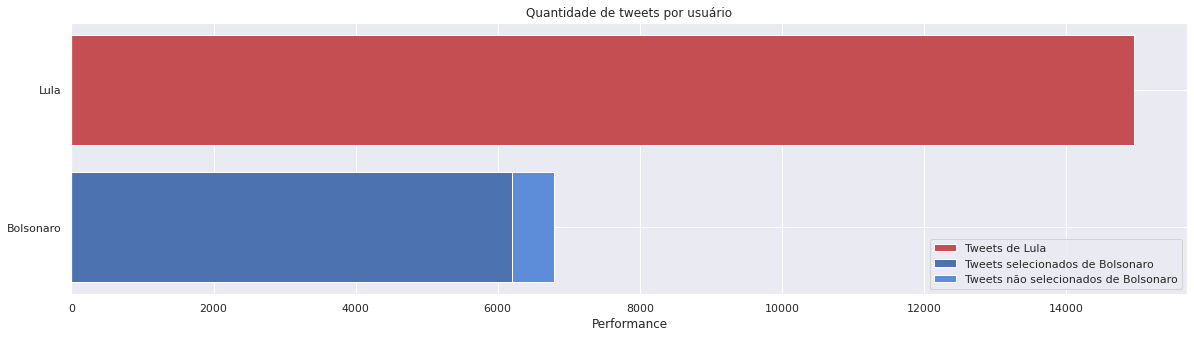

In [127]:
#@title Filtro de tempo para as análises e gráficos

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#@markdown Seleção opcional para período de análise 

datas_relevantes = pd.DataFrame(dict_datas_relevantes.items(), columns=["Data","Evento"])
datas_relevantes['Data'] = datas_relevantes['Data'].astype('datetime64[ns]')
data_inicial = '2015-04-24'  #@param {type: "date"}
data_final = '2020-01-30'  #@param {type: "date"}

#@markdown Os usuários abaixo terão seus tweets selecionados de acordo com as datas acima para análise

Lula = False #@param {type:"boolean"}
Bolsonaro = True #@param {type:"boolean"}

if Bolsonaro:
  bolsonaro_filtrado, bolsonaro_restante = secciona_dataframe(bolso_data, data_inicial, data_final)
else:
  bolsonaro_filtrado, bolsonaro_restante = secciona_dataframe(bolso_data, DATA_INICIAL_GERAL, DATA_FINAL_GERAL)

if Lula :
  lula_filtrado, lula_restante = secciona_dataframe(lula_data, data_inicial, data_final)
  
else:
  lula_filtrado, lula_restante = secciona_dataframe(lula_data, DATA_INICIAL_GERAL, DATA_FINAL_GERAL)



dic_datas = {data_inicial:"Data inicial da análise",
                     data_final:"Data final da análise"}

datas = pd.DataFrame(dic_datas.items(), columns=datas_relevantes.columns)
datas['Data'] = datas['Data'].astype('datetime64[ns]')
# datas['Data'] = pd.to_datetime(datas['Data'])

dados_filtrados = Lula or Bolsonaro

if dados_filtrados:
  datas_relevantes = datas_relevantes.append(datas).sort_values("Data")

col_data=[data_inicial, data_final]
datas = pd.DataFrame(col_data, columns=['data'])

datas = datas.data.astype('datetime64[ns]')


sns.set()
lula = ["Lula", 
        lula_filtrado.shape[0],
        lula_restante.shape[0]]

bolso = ["Bolsonaro",
         bolsonaro_filtrado.shape[0],
         bolsonaro_restante.shape[0]]

dados = pd.DataFrame([lula,bolso], 
                    columns= ['usuario',
                              'tweets_selecionados',
                              'tweets_totais'])

# plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
people = dados.usuario
y_pos = np.arange(len(people))
performance = dados.tweets_selecionados
error = np.random.rand(len(people))
#barra do bolsonaro

lista_legenda = []

ax.barh(0, dados.tweets_selecionados.loc[dados.usuario=='Lula'],  align='center',color='#c44e52')
if Lula and dados.tweets_totais.loc[dados.usuario=='Lula'].values[0]>0:
  ax.barh(0, dados.tweets_totais.loc[dados.usuario=='Lula'],  align='center',color='#d16266',left = dados.tweets_selecionados.loc[dados.usuario=='Lula'])
  lista_legenda.append('Tweets selecionados de Lula')
  lista_legenda.append('Tweets não selecionados de Lula')
else:
  lista_legenda.append('Tweets de Lula')



ax.barh(1, dados.tweets_selecionados.loc[dados.usuario=='Bolsonaro'],  align='center',color='#4c72b0')

if Bolsonaro and dados.tweets_totais.loc[dados.usuario=='Bolsonaro'].values[0]>0:
  ax.barh(1, dados.tweets_totais.loc[dados.usuario=='Bolsonaro'],  align='center',color='#5d8cd9',left = dados.tweets_selecionados.loc[dados.usuario=='Bolsonaro'])
  lista_legenda.append('Tweets selecionados de Bolsonaro')
  lista_legenda.append('Tweets não selecionados de Bolsonaro')
else:
  lista_legenda.append('Tweets de Bolsonaro')




ax.set_yticks(y_pos)
ax.set_yticklabels(dados.usuario)
ax.invert_yaxis()  
ax.set_xlabel('Performance')
ax.set_title('Quantidade de tweets por usuário')
fig.set_size_inches(20,5)
plt.legend(lista_legenda)
print("Selecionados ",lula_filtrado.shape[0], ' dos ',lula_data.shape[0]," tweets do lula")
print("Selecionados ",bolsonaro_filtrado.shape[0], ' dos ',bolso_data.shape[0]," tweets do Bolsonaro")
plt.show()

Selecionados  14961  dos  14961  tweets do lula
Selecionados  6794  dos  6794  tweets do Bolsonaro


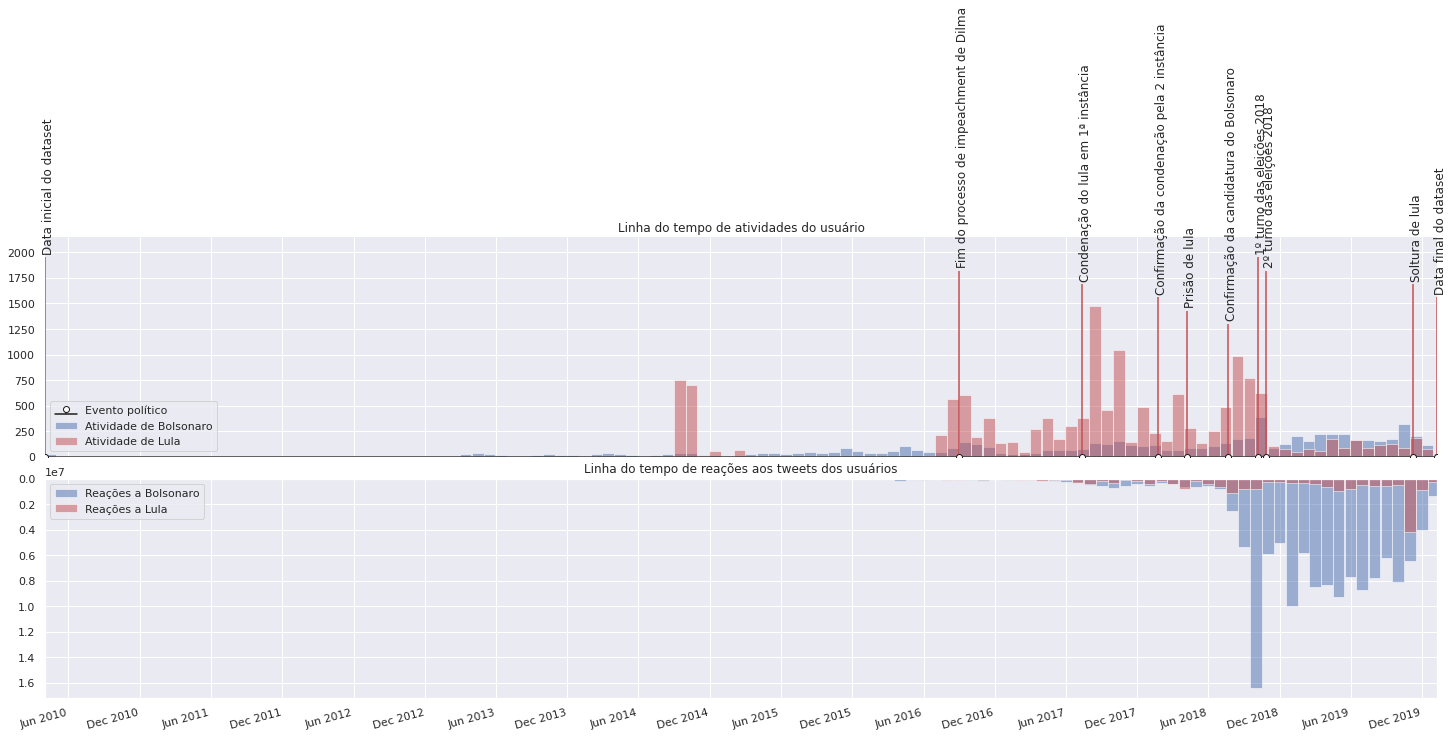

In [520]:
#@title Linha geral do tempo
#@markdown Visualização em gráfico da atividade dos dois políticos ao longo do período abrangido pelos datasets de entrada.

#@markdown Cada barra contém o acumulado mensal de tweets emitidos por cada usuário


data_inicial = '2009-03-24'  #@param {type: "date"}
data_final = '2021-04-30'  #@param {type: "date"}


bolsonaro_filtrado, bolsonaro_restante, data_inicial_bolsonaro, data_final_bolsonaro = secciona_dataframe(bolso_data, 
                                                                                                          data_inicial, 
                                                                                                          data_final)

lula_filtrado, lula_restante, data_inicial_lula, data_final_lula = secciona_dataframe(lula_data, 
                                                                                      data_inicial, 
                                                                                      data_final)
                                                                                   

if bolsonaro_filtrado.shape[0] > 0 and lula_filtrado.shape[0] > 0:
  data_inicial_analise = np.min([bolsonaro_filtrado['created_at'].values.min(),
                              lula_filtrado['created_at'].values.min()])
  data_final_analise = np.max([bolsonaro_filtrado['created_at'].values.max(),
                              lula_filtrado['created_at'].values.max()])
elif bolsonaro_filtrado.shape[0] == 0:
  data_inicial_analise = np.min([lula_filtrado['created_at'].values.min()])
  data_final_analise = np.max([lula_filtrado['created_at'].values.max()])
elif lula_filtrado.shape[0] == 0:
  data_inicial_analise = np.min([bolsonaro_filtrado['created_at'].values.min()]) 
  data_final_analise = np.max([bolsonaro_filtrado['created_at'].values.max()])



#@markdown Opções para modificar a escala dos gráficos

escala_log_grafico_superior = False #@param {type:"boolean"}
escala_log_grafico_inferior = False #@param {type:"boolean"}

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from datetime import datetime
sns.set()

#instanciação do dicionario com datas e eventos relevantes para a análise
dict_datas_relevantes = {DATA_INICIAL_GERAL:"Data inicial do dataset",
                          pd.to_datetime('2016-08-31', format='%Y.%m.%d'):"Fim do processo de impeachment de Dilma",
                          pd.to_datetime('2017-07-12', format='%Y.%m.%d'):'Condenação do lula em 1ª instância',
                          pd.to_datetime('2018-01-24', format='%Y.%m.%d'):'Confirmação da condenação pela 2 instância',
                          pd.to_datetime('2018-04-07', format='%Y.%m.%d'):"Prisão de lula",
                          pd.to_datetime('2018-07-22', format='%Y.%m.%d'):'Confirmação da candidatura do Bolsonaro',
                          pd.to_datetime('2018-10-07', format='%Y.%m.%d'):'1º turno das eleições 2018',
                          pd.to_datetime('2018-10-28', format='%Y.%m.%d'):'2º turno das eleições 2018',
                          pd.to_datetime('2019-11-08', format='%Y.%m.%d'):'Soltura de lula',
                          DATA_FINAL_GERAL:"Data final do dataset"}

datas_relevantes = pd.DataFrame(dict_datas_relevantes.items(), columns=["Data","Evento"])
# datas_relevantes['Data'] = datas_relevantes['Data'].astype('datetime64[ns]')

datas_relevantes_filtrado = datas_relevantes.loc[datas_relevantes['Data']>=data_inicial_analise]
datas_relevantes_filtrado = datas_relevantes_filtrado.loc[datas_relevantes_filtrado['Data']<=data_final_analise]
# datas_relevantes_filtrado = datas_relevantes.loc[datas_relevantes['Data'].between(data_inicial_analise,
#                                                                                   data_final_analise,
#                                                                                   inclusive = True)]

eventos = datas_relevantes_filtrado['Evento']

dates = datas_relevantes_filtrado['Data']


fig, (ax,ax1) = plt.subplots(2,1,sharex=True)
ax.set(title="Linha do tempo de atividades do usuário")

levels = np.tile([1.5, 1.4, 1.3,1.2,1.1,1],
                 int(np.ceil(len(dates)/6)))[:len(dates)]*1300



markerline, stemline, baseline = ax.stem(dates, levels,
                                         linefmt="C3-", basefmt="k-",
                                         use_line_collection=True)
plt.setp(markerline, mec="k", mfc="w", zorder=3)



# formata o eixo  em intervalos de 6 meses
ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=6))
ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax.get_xticklabels(), rotation=15, ha="right")

# remove y axis and spines
#ax.get_yaxis().set_visible(False)
for spine in ["left", "top", "right"]:
    ax.spines[spine].set_visible(False)



def ajuste_dataset_grafico(dataset):
  df = pd.DataFrame(dataset["created_at"].groupby([dataset["created_at"].dt.year,dataset["created_at"].dt.month]).count())
  df.columns = ['Count']
  df = df.reset_index(level=1)
  df.columns = ['Mes','Count']
  df = df.reset_index(level=0)
  df.columns = ['Ano', 'Mes','Count']
  df['datetime'] =pd.to_datetime( dict(year=df.Ano, month=df.Mes, day=15))
  df['datetime'] = df['datetime'].astype('datetime64[ns]')
  return df

b = ajuste_dataset_grafico(bolsonaro_filtrado)
l = ajuste_dataset_grafico(lula_filtrado)
larguraBarra= 30


ax.bar(x=b["datetime"],height=b['Count'],width = larguraBarra, color='b', alpha=0.5)
ax.bar(x=l["datetime"],height=l['Count'],width = larguraBarra, color='r', alpha=0.5)


# Shift the markers to the baseline by replacing the y-data by zeros.
markerline.set_ydata(np.zeros(len(dates)))

ax.legend(['Evento político','Atividade de Bolsonaro','Atividade de Lula'],loc= 'lower left')


# annotate lines
vert = np.array(['top', 'bottom'])[(levels > 0).astype(int)]
for d, l, r, va in zip(dates, levels, eventos, vert):
    
    ax.annotate(r, xy=(d, l), xytext=(-3, np.sign(l)*3),
                textcoords="offset points", va=va, ha="left", rotation=90)

ax1.set(title="Linha do tempo de reações aos tweets dos usuários")


def ajuste_dataset_dataset_grafico_reacoes(dataset,colunas):

  col = colunas.copy()
  col.insert(0,'created_at')
  data = dataset[col].groupby([dataset["created_at"].dt.year,dataset["created_at"].dt.month]).sum()
  data = data.reset_index(level=1)
  col = colunas.copy()
  col.insert(0,'Mes')
  data.columns = col.copy()
  data = data.reset_index(level=0)
  col.insert(0,'Ano')
  data.columns = col.copy()
  data['datetime'] = pd.to_datetime( dict(year=data.Ano, month=data.Mes, day=1))
  data['datetime'] = data['datetime'].astype('datetime64[ns]')

  return data
colunas = ['retweet_count','favorite_count']
b = ajuste_dataset_dataset_grafico_reacoes(bolsonaro_filtrado,colunas)
l = ajuste_dataset_dataset_grafico_reacoes(lula_filtrado,colunas)

larguraBarra= 30
ax1.bar(x=b["datetime"],height=b[colunas[0]]+b[colunas[1]],width = larguraBarra, color='b', alpha=0.5)
ax1.bar(x=l["datetime"],height=l[colunas[0]]+l[colunas[1]],width = larguraBarra, color='r', alpha=0.5)


ax1.legend(['Reações a Bolsonaro','Reações a Lula'])

ax1.invert_yaxis()
ax1.set_yscale('log')
ax.set_yscale('log')
if escala_log_grafico_superior:
  ax.set_yscale('log')
else:
  ax.set_yscale('linear')
if escala_log_grafico_inferior :
  ax1.set_yscale('log')
else:
  ax1.set_yscale('linear')


ax.set_xmargin(0.1)


ax1.get_xaxis().set_major_locator(mdates.MonthLocator(interval=6))
ax1.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(ax1.get_xticklabels(), rotation=15, ha="right")

# ax1.set_yscale()
ax.set_xlim(data_inicial_analise,data_final_analise)

ax.margins(y=0.1)
fig.set_size_inches(20,10)
fig.tight_layout(pad=0.0)
print("Selecionados ",lula_filtrado.shape[0], ' dos ',lula_data.shape[0]," tweets do lula")
print("Selecionados ",bolsonaro_filtrado.shape[0], ' dos ',bolso_data.shape[0]," tweets do Bolsonaro")
plt.show()

In [140]:
bolsonaro_restante

,created_at,id,full_text,retweet_count,favorite_count,favorited,retweeted,character_count,hashtags,user_mentions


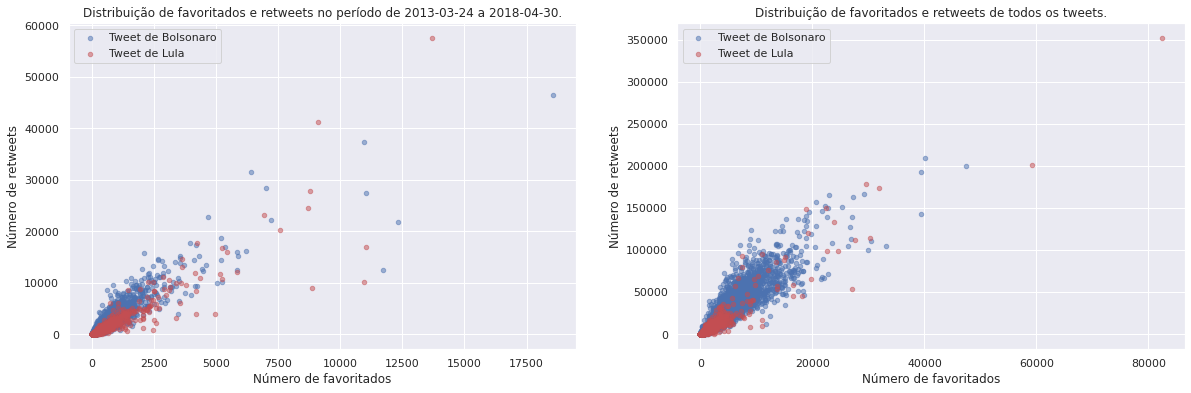

In [359]:
#@title Análise de dispersão das reações
#@markdown Visualização em gráfico de dispersão de quantidade de 'retweets' e quantidade de 'favoritado'. Os pontos azuis representam os tweets de Bolsonaro e os vermelhos representam os tweets de lula
data_inicial = '2013-03-24'  #@param {type: "date"}
data_final = '2018-04-30'  #@param {type: "date"}


bolso_filtrado, bolsonaro_restante, data_inicial_bolsonaro, data_final_bolsonaro = secciona_dataframe(bolso_data, 
                                                                                                          data_inicial, 
                                                                                                          data_final)

lula_filtrado, lula_restante, data_inicial_lula, data_final_lula = secciona_dataframe(lula_data, 
                                                                                      data_inicial, 
                                                                                      data_final)
                                                                                   


#@markdown Por se tratar de uma variável com alguns outliers é recomendado que se utilize uma escala logaritmica para sua representação. Entretanto ao utilizar a escala logaritmica perde-se o senso da diferença entre as reações aos tweets dos dois usuários.
escala_log = False #@param {type:"boolean"}
#uso do estilo do seaborn



fig, (ax,ax1) = plt.subplots(1,2)


def configura_eixo(bolso,lula,ax,escala_log):



  if bolso.shape[0] > 0 and lula.shape[0] > 0:
    data_inicial_analise = np.min([bolso['created_at'].values.min(),
                              lula['created_at'].values.min()])
    data_final_analise = np.max([bolso['created_at'].values.max(),
                              lula['created_at'].values.max()])
  elif bolso.shape[0] == 0:
    data_inicial_analise = np.min([lula['created_at'].values.min()])
    data_final_analise = np.max([lula['created_at'].values.max()])
  elif lula.shape[0] == 0:
    data_inicial_analise = np.min([bolso['created_at'].values.min()]) 
    data_final_analise = np.max([bolso['created_at'].values.max()])
  


  if escala_log:
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim(xmin=10,xmax=100000000)
    ax.set_ylim(ymin=10,ymax=100000000)
  else:
    ax.set_yscale('linear')
    ax.set_xscale('linear')
  sns.set()

  somaB = bolso['favorite_count'] + bolso['retweet_count']
  somaL = lula['favorite_count'] + lula['retweet_count']


  if somaB.mean() >= somaL.mean():  
    ax.scatter(y= bolso['favorite_count'], x= bolso['retweet_count'], color = 'b',s=20,alpha=0.5)
    ax.scatter(y= lula['favorite_count'], x= lula['retweet_count'],  color = 'r',s=20,alpha=0.5)
    ax.legend(['Tweet de Bolsonaro','Tweet de Lula'])
  else:
    ax.scatter(y= lula['favorite_count'], x= lula['retweet_count'],  color = 'r',s=20,alpha=0.5)
    ax.scatter(y= bolso['favorite_count'], x= bolso['retweet_count'], color = 'b',s=20,alpha=0.5)
    ax.legend(['Tweet de Lula','Tweet de Bolsonaro'])
  # Set the x-axis label
  ax.set_xlabel("Número de favoritados")

  # Set the y-axis label
  ax.set_ylabel("Número de retweets")
  
  # ax.set_xlim(0,350000)

  return ax
ax = configura_eixo(bolso_filtrado,lula_filtrado,ax,escala_log)

ax.set_title(''.join(["Distribuição de favoritados e retweets no período de ",
                          data_inicial,
                          " a ", 
                          data_final,
                          "."]))




ax1 = configura_eixo(bolso_data,lula_data,ax1,escala_log)
ax1.set_title(''.join(["Distribuição de favoritados e retweets de todos os tweets."]))
fig.set_size_inches(20,6)




print("Selecionados ",lula_filtrado.shape[0], ' dos ',lula_data.shape[0]," tweets do lula")
print("Selecionados ",bolsonaro_filtrado.shape[0], ' dos ',bolso_data.shape[0]," tweets do Bolsonaro")
plt.show()

2ª Etapa de limpeza de dados:

*   Foco no texto dos tweets
*   Retirada de caracteres especiais
*   Vetorização e contagem dos tokens



In [0]:
import re
import string
from nltk.corpus import stopwords as sw
from string import punctuation
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer
from nltk.tokenize import TweetTokenizer
from contextlib import redirect_stdout
import os

#entra string
def tratamento_inicial(tweet):

  
  tweet = tweet.lower()
  tweet = tweet.strip()
  #remove os links
  tweet = re.sub(r'https?://\w+\.\w+\/\w+', '', tweet, flags=re.MULTILINE)
  #substitui ñ e n por não
  tweet = re.sub('^ñ$', 'não', tweet, flags=re.MULTILINE)
  tweet = re.sub('^n$', 'não', tweet, flags=re.MULTILINE)
  
  #remove as quebras de linha
  tweet = re.sub(r'\n', '', tweet)
  
  #substitui tabulações por um espaço em branco
  tweet = re.sub(r'\t', ' ', tweet)
  #substitui um ou mais espaços em branco por um espaço
  tweet= re.sub(r'\s+', ' ', tweet, flags=re.I)
  #&amp;
  #remove qualquer palavra que contenha um número, ou seja, uma palavra com erro de digitação
  tweet = re.sub('\w*\d\w*', '', tweet)
  #remove aspas e apóstofres
  tweet = re.sub('[\'"‘’“”…]', '', tweet)
  #devolv um tweet tratado  
  tweet = re.sub('brasil', 'Brasil', tweet, flags=re.MULTILINE)
  
  
  return tweet  

#entra string
def tokeniza(tweet):

  tokenizador = TweetTokenizer()

  tokens = tokenizador.tokenize(tweet)

  # tokens = [w for w in tokens if not w in lista_remocao and len(w)>1]
  tokens = [w for w in tokens if len(w)>1]
  
  #sai lista de tokens
  return tokens

#entra serie
def vetoriza(serie):
  
  with redirect_stdout(open(os.devnull, "w")):
    nltk.download("stopwords") 
    nltk.download('punkt')
  
  stopwords = sw.words('portuguese')
  
  lista_palavras = []

  lista_palavras = ['...','ser','boa','bom','dia','pra','hoje']

  lista_remocao = set(stopwords + list(punctuation) + lista_palavras)

  
  tfidf = TfidfVectorizer()
  tfidf = TfidfVectorizer(norm = None,
                          use_idf = False,
                          preprocessor = tratamento_inicial,
                          tokenizer = tokeniza,
                          lowercase = False,
                          stop_words = lista_remocao)


  data_tfidf = tfidf.fit_transform(serie)
  


  data = pd.DataFrame(data_tfidf.toarray())#, columns=tfidf.get_feature_names())
    
  data = pd.DataFrame([data.sum().astype("int"),(data > 0).sum()])
  data.columns = tfidf.get_feature_names()
  data = data.transpose()

  

  data.columns = ['term_count','document_frequency']
  
  data['term_frequency'] = data['term_count']/data.shape[0]
  
  data['inverse_doc_frequency'] = np.log((1+serie.shape[0])/(1+data['document_frequency'])+1)

  data['tfidf'] = data['term_frequency']* data['inverse_doc_frequency']

  data = data.sort_values('tfidf', ascending= False)




  return data


In [517]:
#@title Exemplo de tratamento de dados
#@markdown Obtém-se a tabela abaixo após o processo de tratamento de texto
palavras_bolso_filtrado = vetoriza(bolso_filtrado['full_text'])
palavras_bolso_filtrado.head(30)

,term_count,document_frequency,term_frequency,inverse_doc_frequency,tfidf
Brasil,1267,1210,0.086367,1.888745,0.163125
bolsonaro,811,795,0.055283,2.255119,0.124670
todos,590,560,0.040218,2.573551,0.103503
governo,388,377,0.026449,2.943185,0.077843
sobre,366,352,0.024949,3.008120,0.075049
obrigado,349,333,0.023790,3.060785,0.072816
abraço,319,316,0.021745,3.110637,0.067641
pt,309,304,0.021063,3.147538,0.066298
grande,296,290,0.020177,3.192553,0.064417
jair,273,271,0.018609,3.257389,0.060618


Selecionados  14961  dos  14961  tweets do lula
Selecionados  6794  dos  6794  tweets do Bolsonaro


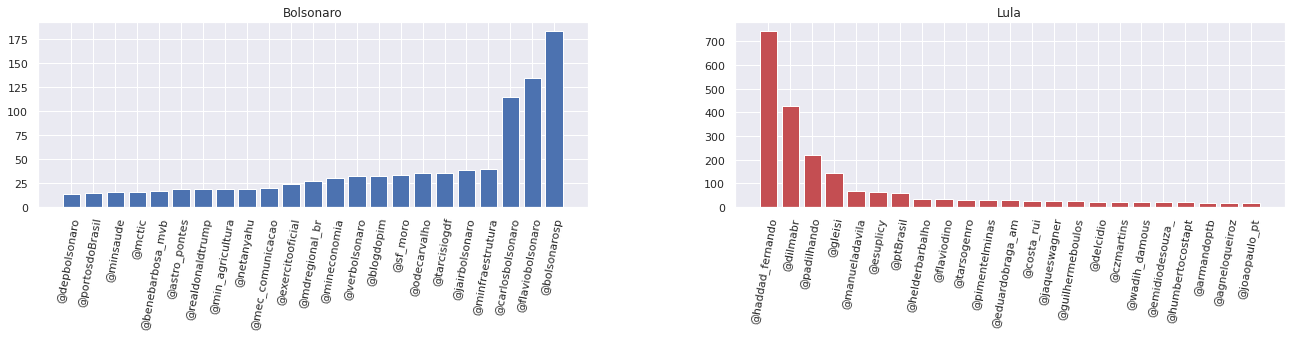

In [503]:
#@title Comparação de vocabulário entre usuários
#@markdown Visualização das palavras mais utilizadas por usuário
data_inicial = '2009-03-24'  #@param {type: "date"}
data_final = '2021-04-30'  #@param {type: "date"}

#@markdown Quantidade de palavras por usuário:

qtd_palavras = 23  #@param {type: "slider", min: 5, max: 30}

#@markdown Busca os termos que contenham a seguinte string:

busca_termo = "@" #@param {type:"string"}

#@markdown Plota o gráfico com a frequência das palavras entre as palavras mais escritas, do contrário será plotada a quantidade de palavras:

por_frequencia = False #@param {type:"boolean"}

  
bolso_filtrado, bolsonaro_restante, data_inicial_bolsonaro, data_final_bolsonaro = secciona_dataframe(bolso_data, 
                                                                                                          data_inicial, 
                                                                                                          data_final)

lula_filtrado, lula_restante, data_inicial_lula, data_final_lula = secciona_dataframe(lula_data, 
                                                                                      data_inicial, 
                                                                                      data_final)

fig, (ax1,ax2) = plt.subplots(1,2,sharey= por_frequencia)


palavras_bolso_filtrado = vetoriza(bolso_filtrado['full_text'])

palavras_lula_filtrado = vetoriza(lula_filtrado['full_text'])


bolsonaro = palavras_bolso_filtrado.loc[palavras_bolso_filtrado.index.str.contains(busca_termo.lower())][0:qtd_palavras]

if por_frequencia:
  altura = bolsonaro['term_count']/bolsonaro['term_count'].sum()
else:
  altura = bolsonaro['term_count']

ax1.bar(bolsonaro.index,
        altura,
        color = 'b')
ax1.invert_xaxis()

ax1.set_title('Bolsonaro')

ax1.set_xticklabels(bolsonaro.index,rotation=80,ha='right',rotation_mode='anchor')


lula = palavras_lula_filtrado.loc[palavras_lula_filtrado.index.str.contains(busca_termo.lower())][0:qtd_palavras]



if por_frequencia:
  altura = lula['term_count']/lula['term_count'].sum()
else:
  altura = lula['term_count']
ax2.bar(lula.index,
        altura,
        color = 'r')


ax2.set_xticklabels(lula.index,rotation=80,ha='right',rotation_mode='anchor')

# ax2.set_yticklabels(['reference', 'something', 'something else', 'nothing', ], 
#                     ha='center', position=(-0.25, 0))
ax2.set_title('Lula')

fig.tight_layout()
sns.set()
fig.set_size_inches(20,6)


print("Selecionados ",lula_filtrado.shape[0], ' dos ',lula_data.shape[0]," tweets do lula")
print("Selecionados ",bolsonaro_filtrado.shape[0], ' dos ',bolso_data.shape[0]," tweets do Bolsonaro")
plt.show()








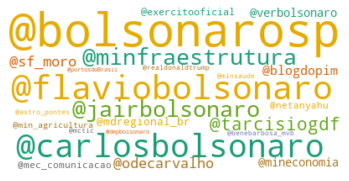

In [497]:
#@title Wordcloud Bolsonaro
#@markdown Visualização das palavras mais utilizadas pelo usuário com a configuração do gráfico de barras


from wordcloud import WordCloud


wc = WordCloud(background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)


wc.generate_from_frequencies(bolsonaro['tfidf'])

plt.subplot()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

    
plt.show()

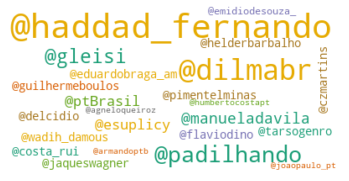

In [498]:
#@title Wordcloud Lula
#@markdown Visualização das palavras mais utilizadas pelo usuário com a configuração do gráfico de barras


from wordcloud import WordCloud


wc = WordCloud(background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)


wc.generate_from_frequencies(lula['tfidf'])

plt.subplot()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

    
plt.show()

Selecionados  1911  tweets para o período antes de  2017-03-24  e  4883  tweets para o período posterior
Totalizando  6794  tweets


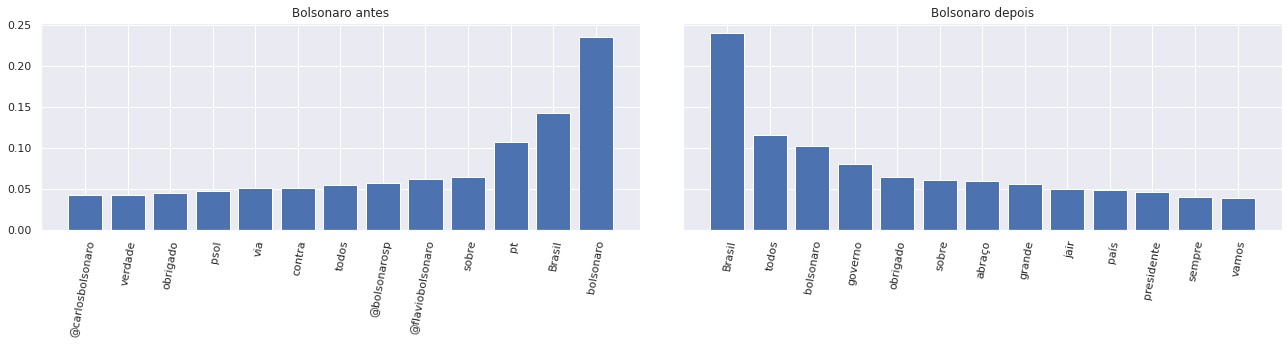

In [509]:
#@title Comparação de vocabulário de Bolsonaro
#@markdown Visualização das palavras mais utilizadas pelo usuário antes e depois da data abaixo
data_seccao_dados = '2017-03-24'  #@param {type: "date"}


#@markdown Quantidade de palavras por período

qtd_palavras = 13  #@param {type: "slider", min: 5, max: 30}

#@markdown Busca os termos que contenham a seguinte string:

busca_termo = "" #@param {type:"string"}

#@markdown Plota o gráfico com a frequência das palavras entre as palavras mais escritas, do contrário será plotada a quantidade de palavras:

por_frequencia = True #@param {type:"boolean"}




bolso_antes, bolso_depois, data_inicial_bolsonaro, data_final_bolsonaro = secciona_dataframe(bolso_data, data_seccao_dados)


fig, (ax1,ax2) = plt.subplots(1,2,sharey= por_frequencia)


palavras_bolso_antes = vetoriza(bolso_antes['full_text'])

palavras_bolso_depois = vetoriza(bolso_depois['full_text'])


bolsonaro_antes = palavras_bolso_antes.loc[palavras_bolso_antes.index.str.contains(busca_termo.lower())][0:qtd_palavras]

if por_frequencia:
  altura = bolsonaro_antes['term_count']/bolsonaro_antes['term_count'].sum()
else:
  altura = bolsonaro_antes['term_count']

ax1.bar(bolsonaro_antes.index,
        altura,
        color = 'b')
ax1.invert_xaxis()

ax1.set_title('Bolsonaro antes')

ax1.set_xticklabels(bolsonaro_antes.index,rotation=80,ha='right',rotation_mode='anchor')


bolsonaro_depois = palavras_bolso_depois.loc[palavras_bolso_depois.index.str.contains(busca_termo.lower())][0:qtd_palavras]



if por_frequencia:
  altura = bolsonaro_depois['term_count']/bolsonaro_depois['term_count'].sum()
else:
  altura = bolsonaro_depois['term_count']
ax2.bar(bolsonaro_depois.index,
        altura,
        color = 'b')


ax2.set_xticklabels(bolsonaro_depois.index,rotation=80,ha='right',rotation_mode='anchor')

# ax2.set_yticklabels(['reference', 'something', 'something else', 'nothing', ], 
#                     ha='center', position=(-0.25, 0))
ax2.set_title('Bolsonaro depois')

fig.tight_layout()
sns.set()
fig.set_size_inches(20,6)


print("Selecionados ",bolso_antes.shape[0], ' tweets para o período antes de ',data_seccao_dados,' e ', bolso_depois.shape[0],' tweets para o período posterior')
print("Totalizando ",bolso_depois.shape[0] + bolso_antes.shape[0], ' tweets')
plt.show()








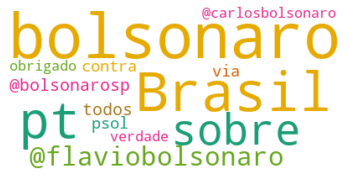

In [511]:
#@title Wordcloud Bolsonaro antes
#@markdown Visualização das palavras mais utilizadas por Bolsonaro no período anterior à data especificada


from wordcloud import WordCloud


wc = WordCloud(background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)


wc.generate_from_frequencies(bolsonaro_antes['tfidf'])

plt.subplot()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

    
plt.show()

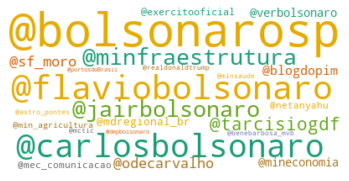

In [0]:
#@title Wordcloud Bolsonaro depois
#@markdown Visualização das palavras mais utilizadas por Bolsonaro no período posterior à data especificada


from wordcloud import WordCloud


wc = WordCloud(background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)


wc.generate_from_frequencies(bolsonaro_depois['tfidf'])

plt.subplot()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

    
plt.show()

Selecionados  13  tweets para o período antes de  2017-03-24  e  13  tweets para o período posterior
Totalizando  26  tweets


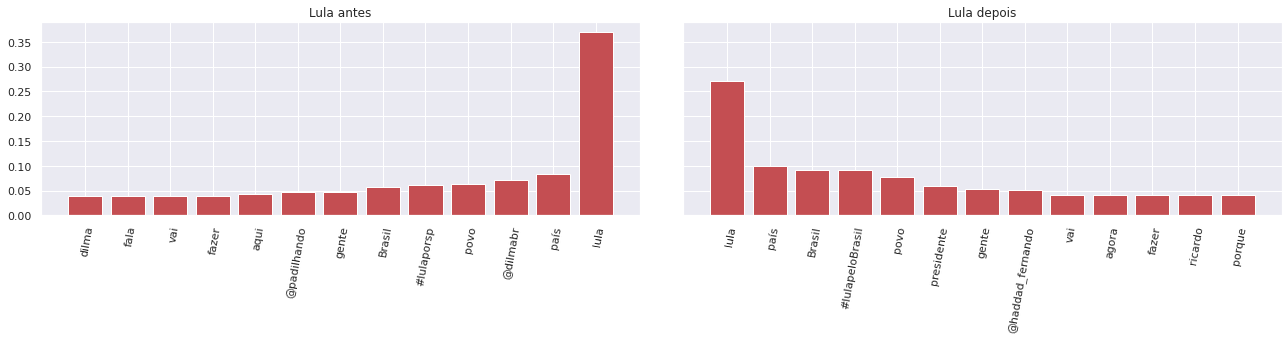

In [513]:
#@title Comparação de vocabulário de Lula
#@markdown Visualização das palavras mais utilizadas pelo usuário antes e depois da data abaixo
data_seccao_dados = '2017-03-24'  #@param {type: "date"}


#@markdown Quantidade de palavras por período

qtd_palavras = 13  #@param {type: "slider", min: 5, max: 30}

#@markdown Busca os termos que contenham a seguinte string:

busca_termo = "" #@param {type:"string"}

#@markdown Plota o gráfico com a frequência das palavras entre as palavras mais escritas, do contrário será plotada a quantidade de palavras:

por_frequencia = True #@param {type:"boolean"}




lula_antes, lula_depois, data_inicial_lula, data_final_lula = secciona_dataframe(lula_data, data_seccao_dados)


fig, (ax1,ax2) = plt.subplots(1,2,sharey= por_frequencia)


palavras_lula_antes = vetoriza(lula_antes['full_text'])

palavras_lula_depois = vetoriza(lula_depois['full_text'])


lula_antes = palavras_lula_antes.loc[palavras_lula_antes.index.str.contains(busca_termo.lower())][0:qtd_palavras]

if por_frequencia:
  altura = lula_antes['term_count']/lula_antes['term_count'].sum()
else:
  altura = lula_antes['term_count']

ax1.bar(lula_antes.index,
        altura,
        color = 'r')
ax1.invert_xaxis()

ax1.set_title('Lula antes')

ax1.set_xticklabels(lula_antes.index,rotation=80,ha='right',rotation_mode='anchor')


lula_depois = palavras_lula_depois.loc[palavras_lula_depois.index.str.contains(busca_termo.lower())][0:qtd_palavras]



if por_frequencia:
  altura = lula_depois['term_count']/lula_depois['term_count'].sum()
else:
  altura = lula_depois['term_count']
ax2.bar(lula_depois.index,
        altura,
        color = 'r')


ax2.set_xticklabels(lula_depois.index,rotation=80,ha='right',rotation_mode='anchor')

# ax2.set_yticklabels(['reference', 'something', 'something else', 'nothing', ], 
#                     ha='center', position=(-0.25, 0))
ax2.set_title('Lula depois')

fig.tight_layout()
sns.set()
fig.set_size_inches(20,6)


print("Selecionados ",lula_antes.shape[0], ' tweets para o período antes de ',data_seccao_dados,' e ', lula_depois.shape[0],' tweets para o período posterior')
print("Totalizando ",lula_depois.shape[0] + lula_antes.shape[0], ' tweets')
plt.show()








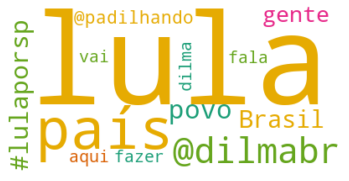

In [514]:
#@title Wordcloud Lula antes
#@markdown Visualização das palavras mais utilizadas por Lula no período anterior à data especificada


from wordcloud import WordCloud


wc = WordCloud(background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)


wc.generate_from_frequencies(lula_antes['tfidf'])

plt.subplot()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

    
plt.show()

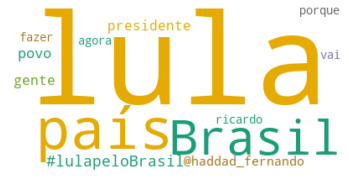

In [515]:
#@title Wordcloud Lula depois
#@markdown Visualização das palavras mais utilizadas por Lula no período posterior à data especificada


from wordcloud import WordCloud


wc = WordCloud(background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)


wc.generate_from_frequencies(lula_depois['tfidf'])

plt.subplot()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")

    
plt.show()

Próximos passos:

- Lematização e stemmização
- Análises estatísticas